# lib

In [58]:
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, Activation, BatchNormalization

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

# preprocessing data

In [59]:
import pandas_ta as ta

In [60]:
path_to_file = "btc.csv"

In [61]:
btc = pd.read_csv(path_to_file, skiprows=1)
btc = btc[::-1]
btc = btc[2100:]
btc = btc.astype({'date': 'datetime64'}).set_index('date')
btc = btc.drop(['unix', 'symbol','Volume USD'], axis=1)
df = btc
df.head()

,open,high,low,close,Volume BTC
date,,,,,
2020-08-28,11332.26,11555.61,11277.95,11536.58,6046.497464
2020-08-29,11538.74,11592.00,11423.64,11471.71,2095.936003
2020-08-30,11471.71,11715.69,11458.62,11708.97,2328.657019
2020-08-31,11713.11,11780.00,11573.39,11655.00,4534.218102
2020-09-01,11658.48,12065.82,11515.00,11923.96,7960.822380


<AxesSubplot:title={'center':'Bitcoin Weighted Price'}, xlabel='date'>

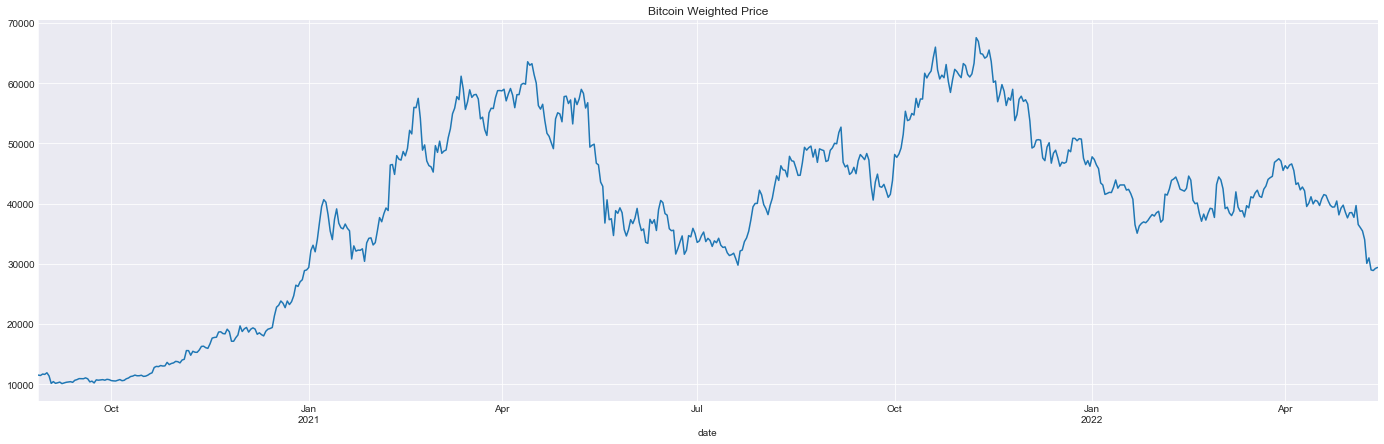

In [62]:
# btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")
btc.close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

In [63]:
dff = (df.iloc[1:].reset_index(drop=True).copy()/df.iloc[:-1].reset_index(drop=True).copy())
dff_y = (df.iloc[1:].reset_index(drop=True).copy()/df.iloc[:-1].reset_index(drop=True).copy())

scaler = StandardScaler()

dff.open = scaler.fit_transform(dff.open.values.reshape(-1,1))

dff.high = scaler.fit_transform(dff.high.values.reshape(-1,1))

dff.low = scaler.fit_transform(dff.low.values.reshape(-1,1))

dff.close = scaler.fit_transform(dff.close.values.reshape(-1,1))

dff = dff.drop('Volume BTC',axis=1)



In [64]:
len_ = 30
def train_test_split(df):
    split_row = len(df) - int(0.04 * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

def extract_windows_data(df):
    window_data = []
    for idx in range(len(df) - len_):
        tmp = df[idx: (idx + len_)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df,dff_y):
    train_data, test_data = train_test_split(df)
    train_data_, test_data_ = train_test_split(dff_y)
    X_train = extract_windows_data(train_data)
    X_test = extract_windows_data(test_data)
    y_train = train_data_['close'][len_:].values
    y_test = test_data_['close'][len_:].values
    y_train[y_train > 1] = 1
    y_train[y_train < 1] = 0
    y_test[y_test > 1] = 1
    y_test[y_test < 1] = 0
    return train_data, test_data, X_train, X_test, y_train, y_test


train, test, X_train, X_test, y_train, y_test = prepare_data(dff,dff_y)




print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train[:2])

X_train[0]

(570, 30, 4)
(570,)
(0,)
(0,)
[0. 1.]


array([[ 0.41002234,  0.03213422,  0.24247557, -0.20258068],
       [-0.20786127,  0.25546787,  0.01369428,  0.47384579],
       [ 0.48259883,  0.10162116,  0.17511158, -0.17651388],
       [-0.17841635,  0.65909454, -0.17449362,  0.53542215],
       [ 0.5172696 , -0.33053551, -0.78243614, -1.19129683],
       [-1.18981356, -1.25122702, -2.48666171, -2.85187663],
       [-2.84552622, -2.21028987, -0.25592661,  0.69198704],
       [ 0.70126968, -0.28129002, -0.18028429, -0.76902765],
       [-0.78299703, -0.66411241,  0.29610281,  0.17717456],
       [ 0.17665136,  0.1172175 , -0.33593034,  0.23516848],
       [ 0.2399668 ,  0.02563371, -0.18643685, -0.68536883],
       [-0.68163073, -0.32513788,  0.31190745,  0.21846269],
       [ 0.18465242,  0.34691934,  0.49754078,  0.21790957],
       [ 0.24242105, -0.3055593 , -0.10167282,  0.0674449 ],
       [ 0.08841051,  0.14680724,  0.11214888,  0.06644015],
       [ 0.05508965,  0.20592189, -0.19315521, -0.32527038],
       [-0.32329259,  0.

# train

In [65]:
model = Sequential()


model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=16))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dense(units=1))
model.add(Activation('sigmoid'))


model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 30, 256)           267264    
                                                                 
 batch_normalization_15 (Bat  (None, 30, 256)          1024      
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 30, 256)           0         
                                                                 
 lstm_18 (LSTM)              (None, 128)               197120    
                                                                 
 batch_normalization_16 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_22 (Dropout)        (None, 128)              

In [66]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [67]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = 'my_best_model_.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

In [71]:
history = model.fit(X_train, y_train, epochs=5000, batch_size=128, shuffle=True,
                    validation_data=(X_test,y_test), callbacks=callbacks)

Epoch 1/5000
5/5 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9877
Epoch 1: loss did not improve from 0.02313
5/5 [==============================] - 1s 268ms/step - loss: 0.0476 - accuracy: 0.9877
Epoch 2/5000
5/5 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9807
Epoch 2: loss did not improve from 0.02313
5/5 [==============================] - 1s 255ms/step - loss: 0.0504 - accuracy: 0.9807
Epoch 3/5000
5/5 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9754
Epoch 3: loss did not improve from 0.02313
5/5 [==============================] - 1s 254ms/step - loss: 0.0572 - accuracy: 0.9754
Epoch 4/5000
5/5 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9807
Epoch 4: loss did not improve from 0.02313
5/5 [==============================] - 1s 246ms/step - loss: 0.0550 - accuracy: 0.9807
Epoch 5/5000
5/5 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9789
Epoch 5: l

5/5 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9860
Epoch 37: loss did not improve from 0.02313
5/5 [==============================] - 1s 251ms/step - loss: 0.0375 - accuracy: 0.9860
Epoch 38/5000
5/5 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9825
Epoch 38: loss did not improve from 0.02313
5/5 [==============================] - 1s 241ms/step - loss: 0.0487 - accuracy: 0.9825
Epoch 39/5000
5/5 [==============================] - ETA: 0s - loss: 0.0479 - accuracy: 0.9825
Epoch 39: loss did not improve from 0.02313
5/5 [==============================] - 1s 256ms/step - loss: 0.0479 - accuracy: 0.9825
Epoch 40/5000
5/5 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9877
Epoch 40: loss did not improve from 0.02313
5/5 [==============================] - 1s 253ms/step - loss: 0.0425 - accuracy: 0.9877
Epoch 41/5000
5/5 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9860
Epoch 41: loss 

5/5 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9877
Epoch 73: loss did not improve from 0.02313
5/5 [==============================] - 1s 278ms/step - loss: 0.0388 - accuracy: 0.9877
Epoch 74/5000
5/5 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9877
Epoch 74: loss did not improve from 0.02313
5/5 [==============================] - 1s 270ms/step - loss: 0.0338 - accuracy: 0.9877


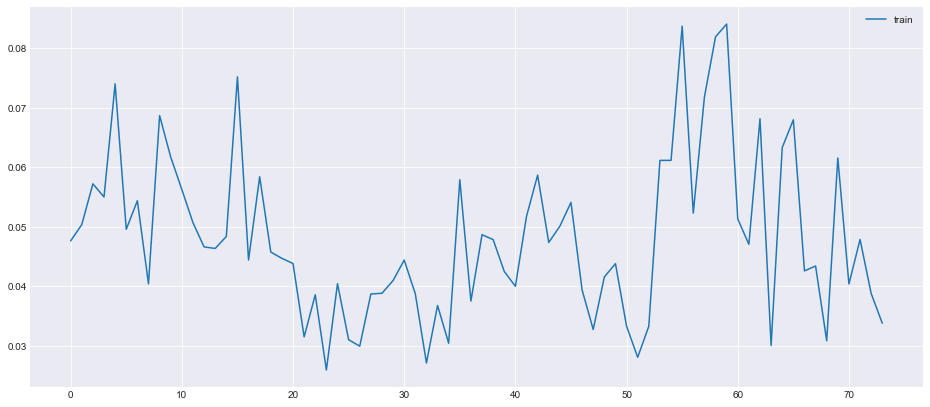

In [72]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

# plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()